# Exercise 1
- Apply f_classif from sklearn to assess the discriminative power of the input variables. Identify the input variable with the highest and lowest discriminative power. Plot the class-conditional probability density functions of these two input variables

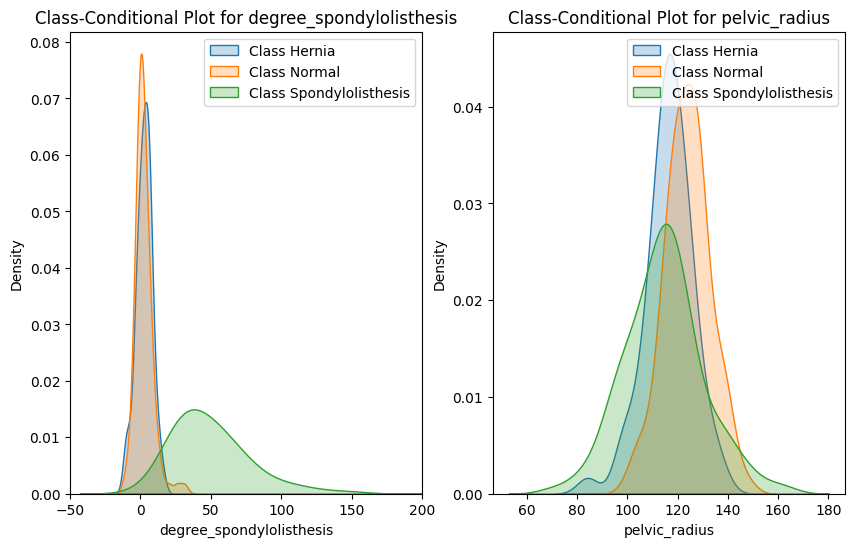

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from scipy.io.arff import loadarff

# Imports data, converts and selects highest and lowest discriminative power input variables
data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')
X = df.drop('class', axis=1)
y = df['class']
fimportance = f_classif(X, y)
max_score = np.argmax(fimportance[0])
min_score = np.argmin(fimportance[0])
max_score_label = X.columns.values[max_score]
min_score_label = X.columns.values[min_score]

# Prob density function plot for highest discriminative power variable
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for class_ in np.unique(y):
    subset = X[y == class_][max_score_label]
    sns.kdeplot(subset, label=f'Class {class_}', fill=True)
plt.title(f'Class-Conditional Plot for {max_score_label}')
plt.xlabel(max_score_label)
plt.ylabel('Density')
plt.xlim((-50, 200))
plt.legend()
# Prob density function plot for lowest discriminative power variable
plt.subplot(1, 2, 2)
for class_ in np.unique(y):
    subset = X[y == class_][min_score_label]
    sns.kdeplot(subset, label=f'Class {class_}', fill=True)
plt.title(f'Class-Conditional Plot for {min_score_label}')
plt.xlabel(min_score_label)
plt.ylabel('Density')
plt.legend()
plt.show()


# Exercise 2
- Using a stratified 70-30 training-testing split with a fixed seed (random_state=0), assess in a single plot both the training and testing accuracies of a decision tree with depth limits in {1,2,3,4,5,6,8,10} and the remaining parameters as default.

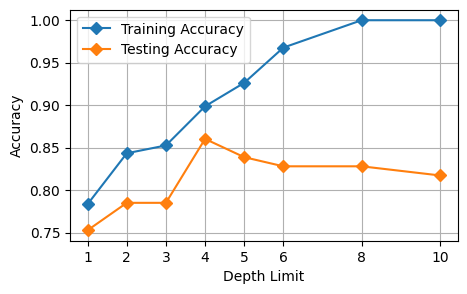

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Loads ARFF data
from scipy.io import arff
data, meta = arff.loadarff('column_diagnosis.arff')
df = pd.DataFrame(data)
df['class'] = df['class'].str.decode('utf-8')

# Extract features and labels
X = df.drop('class', axis=1)
y = df['class']

# Splits data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

# Relevant arrays
train_accuracies, test_accuracies = [], []
depth_limits = [1, 2, 3, 4, 5, 6, 8, 10]

# Calculates accuracies for each depth limit
for depth_limit in depth_limits:
    predictor = DecisionTreeClassifier(max_depth=depth_limit)
    predictor.fit(X_train, y_train)
    train_accuracies.append(predictor.score(X_train, y_train))
    test_accuracies.append(predictor.score(X_test, y_test))
    
# Creates a plot for both accuracies
plt.figure(figsize=(5, 3))
plt.xlabel('Depth Limit')
plt.ylabel('Accuracy')
plt.xticks(depth_limits)
plt.plot(depth_limits, train_accuracies, marker='D', label='Training Accuracy')
plt.plot(depth_limits, test_accuracies, marker='D', label='Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 2 (Optional)
- Note that split thresholding of numeric variables in decision trees is non-deterministic in sklearn, hence you may opt to average the results using 10 runs per parameterization.


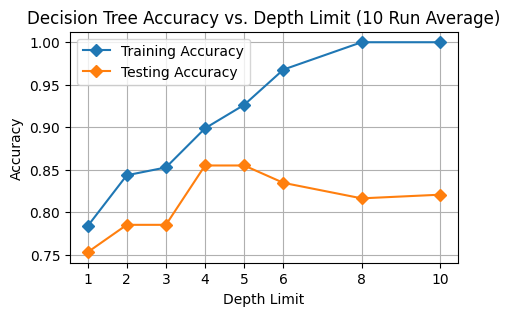

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy.io import arff

# Same thing as above basically
data, meta = arff.loadarff('column_diagnosis.arff')
df = pd.DataFrame(data)
df['class'] = df['class'].str.decode('utf-8')
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

train_accuracies = []
test_accuracies = []
depth_limits = [1, 2, 3, 4, 5, 6, 8, 10]
num_runs = 10  

# Calculates num_runs accuracies for each depth limit
for depth_limit in depth_limits:
    train_accuracy_sum = test_accuracy_sum = 0
    for _ in range(num_runs):
        predictor = DecisionTreeClassifier(max_depth=depth_limit)
        predictor.fit(X_train, y_train)
        
        train_accuracy_sum += predictor.score(X_train, y_train)
        test_accuracy_sum += predictor.score(X_test, y_test)

    # Appends results averaged
    train_accuracies.append(train_accuracy_sum / num_runs)
    test_accuracies.append(test_accuracy_sum / num_runs)

# Creates a plot similar to above with avg results
plt.figure(figsize=(5, 3))
plt.title('Decision Tree Accuracy vs. Depth Limit (10 Run Average)')
plt.xlabel('Depth Limit')
plt.ylabel('Accuracy')
plt.xticks(depth_limits)
plt.plot(depth_limits, train_accuracies, marker='D', label='Training Accuracy')
plt.plot(depth_limits, test_accuracies, marker='D', label='Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 3
- Comment on the results, including the generalization capacity across settings.

Com base no gráfico produzido no exercício anterior, podemos observar que a training accuracy cresce constantamente à medida que o depth limit também cresce. Até ao depth limit 4, observa-se igualmente uma tendência crescente consistente da testing accuracy e proximidade entre os dados de treino e os dados de teste. Entre o depth limit 4 e 5, a testing accuracy mantém-se constante enquanto a training accuracy cresce e a partir do depth limit 6 a diferença entre ambas torna-se cada vez maior. Esta observação aliada ao facto da training accuracy continuar a crescer cada vez mais até atingir 100% de accuracy (possivelmente captando ruído, ou seja, informação irrelevante) indica-nos um claro caso de overfitting do modelo, em que este se ajusta muito bem aos dados de treino mas se torna mais ineficaz a prever dados novos de teste. 
Uma das estratégias possíveis para evitar overfitting é limitar a profundidade da árvore, e a melhor profundidade para o fazer seria quando o depth limit é igual a 4, devido à proximidade entre a training e testing accuracy e ao facto da testing accuracy ser relativamente elevada (cerca de 0.85).

# Exercise 4
- To deploy the predictor, a healthcare team opted to learn a single decision tree (random_state=0) using all available data as training data, and further ensuring that each leaf has a minimum of 20 individuals in order to avoid overfitting risks.
### Exercise 4.1
- Plot the decision tree.

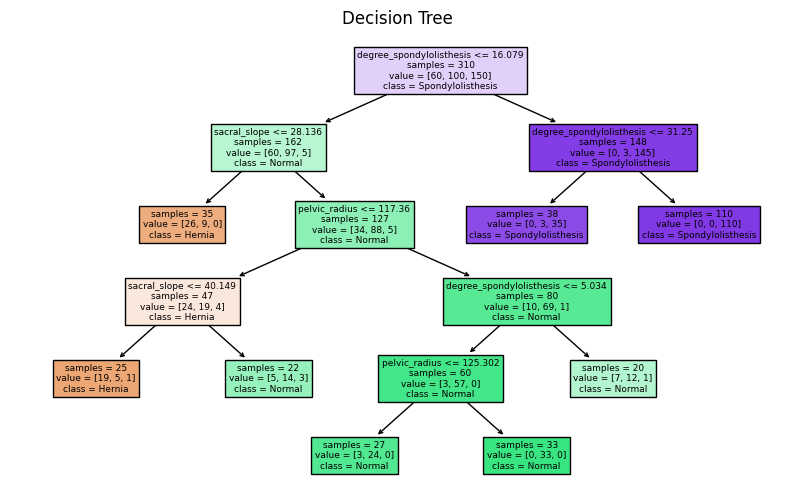

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. load and partition data
from scipy.io import arff
data, meta = arff.loadarff('column_diagnosis.arff')
df = pd.DataFrame(data)
df['class'] = df['class'].str.decode('utf-8')
X = df.drop('class', axis=1)
y = df['class']

# Class names need to be sorted for it to work on the "plot_tree"
df_class_names = df['class'].unique()
df_class_names.sort()

# 2. learn classifier
predictor = DecisionTreeClassifier(random_state=0, min_samples_leaf=20)
predictor.fit(X, y)

# 3. plot classifier
plt.figure(figsize=(10,6))
plot_tree(predictor, filled=True, feature_names=df.columns[:-1], class_names=df_class_names, impurity=False)
plt.title("Decision Tree")
plt.show()

### Exercise 4.2
- Characterize a hernia condition by identifying the hernia-conditional associations.

Com base na árvore de decisão, pode-se caraterizar uma hérnia da seguinte forma: o paciente tem um valor de degree_spondylolisthesis igual ou inferior a 16.079 obrigatoriamente. Daqui em diante, se tiver um valor de sacral_slope igual ou menor a 28.136 é classificado como tendo uma hérnia (1º leaf node possível); se tiver um valor de sacral_slope maior que 28.136 e um pelvic_radius menor ou igual a 117.36, encontra-se numa situação na qual já é mais provável que tenha uma hérnia. Ainda, se a este ponto tiver um sacral_slope menor ou igual a 40.149, é classificado como tendo uma hérnia (2º e último leaf node possível).